<a href="https://colab.research.google.com/github/alura-es-cursos/Inmersion-en-Datos-con-Python/blob/aula02/credito_banco_aleman_inmersion_Dia2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



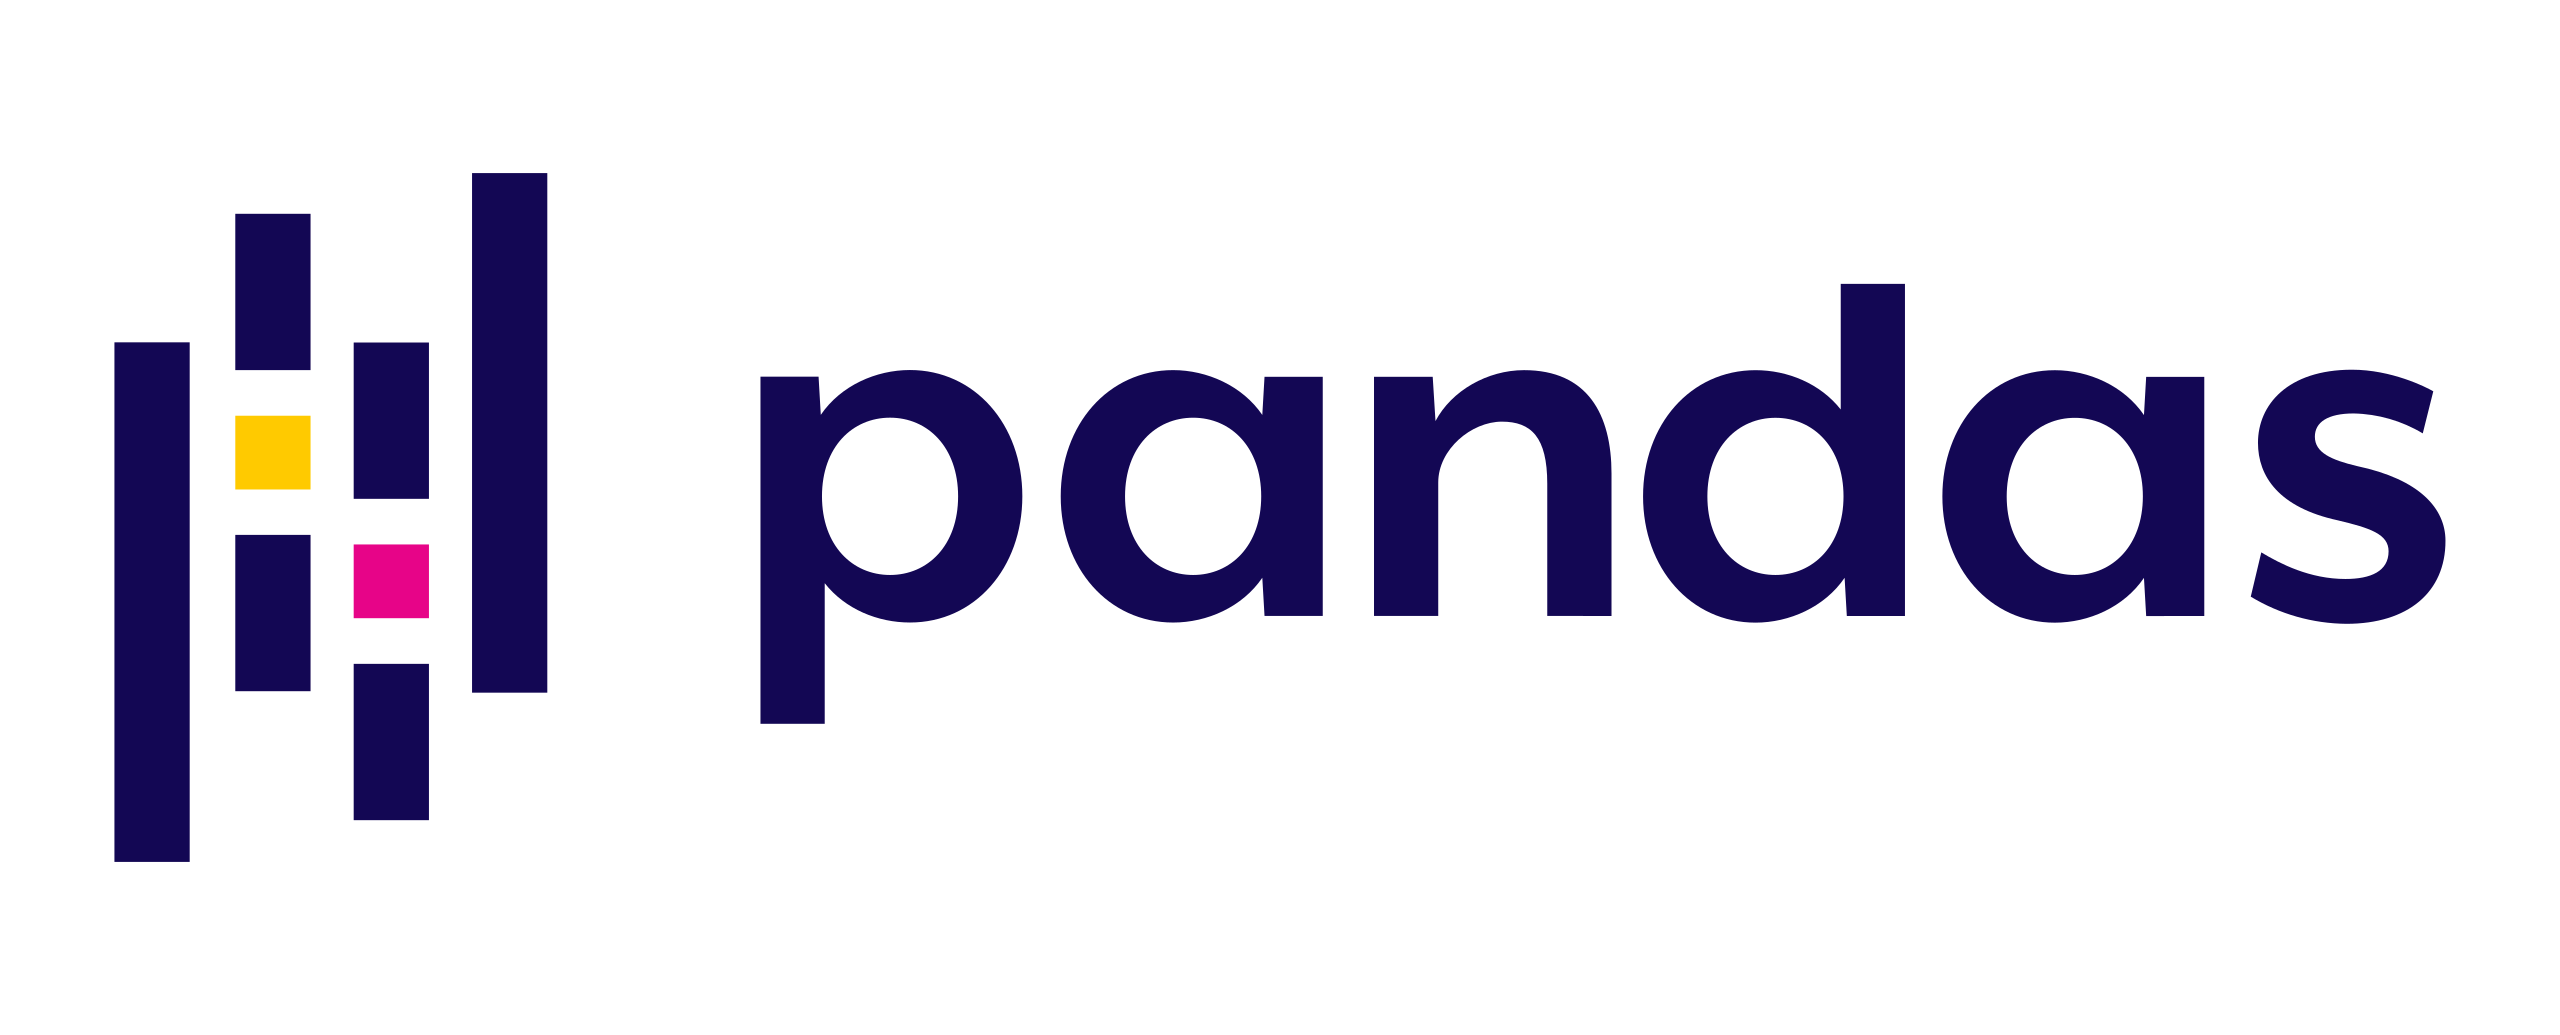

# **Sobre el desafio**

Vamos a contruir un Robot Trading en Python capaz de tomar decisiones de compra y venta de Bitcoin en tiempo real. Basandonos en la media de el valor de cirre en un hiscorico de 7 dias en intervalos de 5 minutos.

# 1. **Configuración del ambiente**

In [221]:
from IPython.display import clear_output
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import time

# variables globales que seutilizaran en el proyecto
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, soup, eleccion_moneda

In [222]:
# comprobar las verciones de las librerias

# !python -V
# print('------')
# !pip show Pandas | grep 'Name\|Version'
# print('------')
# !pip show Numpy | grep 'Name\|Version'
# print('------')
# !pip show Matplotlib | grep 'Name\|Version'


# 2. **Obtención de datos**

In [223]:
def obtener_web():
    """
    Realiza una solicitud a 'https://coinmarketcap.com/', analiza el contenido de la página para obtener
    nombres y abreviaturas de criptomonedas, y permite al usuario buscar una criptomoneda por su nombre o abreviatura.

    Globalmente modifica las siguientes variables:
    - df_bitcoin: DataFrame de pandas para almacenar datos relacionados con Bitcoin.
    - precio_actual: Precio actual de la criptomoneda seleccionada.
    - tendencia: Tendencia actual del mercado.
    - media_bitcoin: Media del precio de Bitcoin.
    - algoritmo_decision: Decisión tomada por el algoritmo.
    - soup: Objeto BeautifulSoup que contiene el contenido HTML de la página.
    - eleccion_moneda: Abreviatura de la criptomoneda seleccionada.

    Raises:
        requests.exceptions.RequestException: Cuando ocurre un error al realizar la solicitud HTTP.
        AttributeError: Cuando ocurre un error de atributo al analizar el HTML de la página.
        TypeError: Cuando ocurre un error de tipo al analizar el HTML de la página.
        Exception: Para capturar cualquier otro tipo de excepción no esperada.

    Returns:
        None
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, soup, eleccion_moneda

    url = 'https://coinmarketcap.com/'
    try:
        # peticiones a la url
        respuesta = requests.get(url)
        # Levantar una excepción si la solicitud no es exitosa
        respuesta.raise_for_status()

        # contenido de la url
        soup = BeautifulSoup(respuesta.content, 'lxml')

        pregunta = input('ingrese el nombre o abrebiatura de la moneda que quieres ver: ')

        # obtener nombres de las cripto monedas de la web
        nombre_moneda = soup.findAll('p', {'class':'sc-4984dd93-0 kKpPOn'})
        abrebiatura_moneda = soup.findAll('p', {'class':'sc-4984dd93-0 iqdbQL coin-item-symbol'})

        # listas para guardar el nombre de las monedas
        nombres_monedas = []
        abrebiatura_monedas = []

        # guardar el nombre de las cripto monedas en las listas antes creadas
        # list(map(lambda nombre: nombres_monedas.append(nombre.text.strip()), nombre_moneda))
        # list(map(lambda abrebiatura: abrebiatura_monedas.append(abrebiatura.text.strip()), abrebiatura_moneda))

        # Para nombres_monedas
        for nombre in nombre_moneda:
            nombres_monedas.append(nombre.text.strip())

        # Para abrebiatura_monedas
        for abrebiatura in abrebiatura_moneda:
            abrebiatura_monedas.append(abrebiatura.text.strip())

        dic = dict(zip(nombres_monedas, abrebiatura_monedas))
        print(dic)

        # saber si el input se encuentra en eldiccionario
        # Buscar input en llaves del diccionario (nombre_moneda)
        if pregunta.capitalize() in dic:
            eleccion_moneda = dic[pregunta.capitalize()]
        elif pregunta.upper() in dic:
            eleccion_moneda = dic[pregunta.upper()]

        # Buscar el valor de la clave en todas las llaves del diccionario (abrebiaturas)
        for clave, valor in dic.items():
            if valor == pregunta.upper():
                eleccion_moneda = valor
                break  # Salir del bucle si se encuentra una coincidencia

        else:
            # Si no se encuentra ninguna coincidencia en ninguno de los casos (if, elif, for)
            print("No se encontró la criptomoneda que busca. Asegúrese de haberla escrito correctamente.\nPor ejemplo: Bitcoin o BTC")

    except requests.exceptions.RequestException as e:
        print("Error al realizar la solicitud a la URL:", e)
    except (AttributeError, TypeError) as e:
        print("Error al analizar el HTML de la página:", e)
    except Exception as e:
        print(type(e), f'No es posible completar la operacion -> Erro: {e}')
    else:
        eleccion_moneda = eleccion_moneda


obtener_web()
eleccion_moneda

ingrese el nombre o abrebiatura de la moneda que quieres ver: btc
{'Bitcoin': 'BTC', 'Ethereum': 'ETH', 'Tether': 'USDT', 'BNB': 'BNB', 'Solana': 'SOL', 'USDC': 'USDC', 'XRP': 'XRP', 'Dogecoin': 'DOGE', 'Toncoin': 'TON', 'Cardano': 'ADA'}


'BTC'

In [224]:
def importar_base_bitcoin():
    """
    Importa datos históricos de precios de la criptomoneda seleccionada y crea un DataFrame con ellos.

    Esta función utiliza la biblioteca yfinance para obtener datos históricos de precios de eleccion_moneda
    para los últimos 7 días con un intervalo de 5 minutos y los almacena en un DataFrame.

    Args:
        No recibe argumentos.

    Returns:
        None

    Global Variables:
        df_bitcoin (pandas.DataFrame): Almacena el DataFrame con los datos históricos de precios de Bitcoin.
        precio_actual (float): Almacena el precio actual de la criptomoneda seleccionada.
        tendencia (str): Almacena la tendencia de los precios de la criptomoneda seleccionada.
        media_bitcoin (float): Almacena la media de los precios de la criptomoneda seleccionada.
        algoritmo_decision (str): Almacena el algoritmo de decisión utilizado para analizar los datos.
        eleccion_moneda (str) : almacena la criptomoneda seleccionada

    Raises:
        yfinance.YFinanceError: Si hay un error al obtener los datos históricos de precios de Bitcoin.
        Exception: Si ocurre un error inesperado durante la ejecución de la función.

    Example:
        >>> importar_base_bitcoin()
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, soup, eleccion_moneda
    try:
        # Crear un objeto Ticker para Bitcoin
        ticker = yf.Ticker(eleccion_moneda+"-USD")
        # Obtener datos históricos de precios para 7 días
        historico_btc = ticker.history(period="7d", interval='5m')
    except yf.YFinanceError as e:
        print("Error al obtener datos históricos:", e)
    except Exception as e:
        print(type(e), f'No es posible completar la operacion -> Erro: {e}')
    else:
        # crear df del historioco del btc para 7 dias en intervalo de 5 minutos
        df_bitcoin = pd.DataFrame(historico_btc)

In [225]:
importar_base_bitcoin()
df_bitcoin.sample(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-04-12 12:55:00+00:00,70472.695312,70496.632812,70428.757812,70496.632812,0,0.0,0.0
2024-04-08 13:10:00+00:00,72128.945312,72128.945312,72007.390625,72007.390625,98945024,0.0,0.0
2024-04-09 05:50:00+00:00,71045.468750,71094.156250,71045.468750,71068.687500,52555776,0.0,0.0
2024-04-09 18:15:00+00:00,68804.703125,68818.242188,68780.515625,68818.242188,0,0.0,0.0
2024-04-09 14:15:00+00:00,70302.656250,70399.054688,70302.656250,70359.859375,0,0.0,0.0


In [226]:
def extraer_tendencias():
    """
    Esta función extrae las tendencias actuales del mercado de la criptomoneda seleccionada desde el sitio web CoinMarketCap.
    Actualiza las variables globales precio_actual, tendencia, soup y eleccion moneda.

    Raises:
    - AttributeError: Si hay un error al analizar el HTML de la página debido a un atributo no encontrado.
    - TypeError: Si hay un error al analizar el HTML de la página debido a un tipo de dato incorrecto.
    - Exception: Si ocurre algún otro error no previsto.

    La función actualiza las variables globales:
    - precio_actual: El precio actual de Bitcoin.
    - tendencia: La tendencia actual del precio de Bitcoin ('alta' si hay un aumento, 'baja' si hay una disminución).
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, soup, eleccion_moneda

    try:
        # obtener las abrebiaturas de las monedas
        moneda_abrebiatura = soup.findAll('p', {'class': 'sc-4984dd93-0 iqdbQL coin-item-symbol'})

        # buscar el indice espesico para la abrebiatura de la moneda bitcoin en la lista moneda_abrebiatura
        indice = 0
        for abrebiatura in moneda_abrebiatura:
            if abrebiatura.getText() == eleccion_moneda:
                break
            indice+=1

        # extraer precio actual de la pagina
        precio_extraido = soup.findAll('div', {'class' : ["sc-500f568e-0 ejtlWy", "sc-500f568e-0 ejtlWy rise", "sc-500f568e-0 ejtlWy fall"]})
        # buscar en la lista precio_extraido por el indice que contiene el BTC
        precio_actual = float(precio_extraido[indice].getText().replace('$', '').replace(',', ''))

        # variación de precio en la última hora
        variacion_precio = soup.findAll('span', {'class' :["sc-6a54057-0 YXxPZ", "sc-6a54057-0 iEhQde"]})
        # extaer valor de la tendencia
        lista = []
        for item in variacion_precio[::3]: #  obtener cada tercer elemento de la lista
            lista.append(item)

        # tendencia
        t = 'baja' if lista[indice].find('span')['class'][0] == 'icon-Caret-down' else 'alta'

    except (AttributeError, TypeError) as e:
        print("Error al analizar el HTML de la página:", e)
    except Exception as e:
        print(type(e), f'No es posible completar la operacion -> Erro: {e}')
    else:
        tendencia = t

In [227]:
extraer_tendencias()
print(precio_actual)
print(tendencia)

66275.15
baja


# 3. **Limpieza de datos**

In [228]:
def limpieza_datos():
    """
    Realiza limpieza de datos en el DataFrame df_bitcoin.

    Esta función realiza una serie de pasos para limpiar el DataFrame df_bitcoin, incluyendo la eliminación de duplicados,
    valores nulos, valores atípicos (outliers) y la selección de registros dentro del rango intercuartílico.

    No tiene parámetros de entrada, pero depende de las variables globales df_bitcoin, precio_actual, tendencia,
    media_bitcoin y algoritmo_decision.

    La función realiza los siguientes pasos:
    1. Copia el DataFrame df_bitcoin y selecciona solo las columnas 'Close' y 'Volume'.
    2. Elimina duplicados en el índice Datetime.
    3. Elimina filas con valores nulos en la columna 'Close'.
    4. Filtra valores de 'Volume' mayores a 0 y elimina las filas correspondientes.
    5. Grafica un boxplot del precio de cierre del Bitcoin.
    6. Identifica outliers basados en el rango intercuartílico y los elimina.
    7. Filtra los registros entre el 1er cuartil y el 3er cuartil del precio de cierre.
    8. Calcula el precio promedio de la selección y lo guarda en la variable global media_bitcoin.

    Ejemplo de uso:
    limpieza_datos()
    print(media_bitcoin)  # Imprime el precio promedio de Bitcoin después de la limpieza de datos.
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision, eleccion_moneda

    df_bitcoin_copy = df_bitcoin.copy()
    df_bitcoin_copy = df_bitcoin_copy[['Close', 'Volume']]
    # eliminar duplicados en el index Datetime
    df_bitcoin_copy.index = df_bitcoin_copy.index.drop_duplicates()
    # eliminar nulos en columna Close
    df_bitcoin_copy = df_bitcoin_copy.dropna(subset=['Close'])
    # filtrar por valores mayores a 0 y eliminarlos
    filtro = df_bitcoin_copy['Volume'] > 0
    df_bitcoin_copy = df_bitcoin_copy[filtro]

    # identificar y eliminar outliers
    # graficar boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot(df_bitcoin_copy['Close'])
    plt.title(f'Boxplot del Precio del {eleccion_moneda}')
    plt.ylabel('Precio')
    plt.show()
    print('\n')
    # Identificar outliers basados en el criterio del rango intercuartílico
    Q1 = df_bitcoin_copy['Close'].quantile(0.25)
    Q3 = df_bitcoin_copy['Close'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df_bitcoin_copy['Close'] < Q1) | (df_bitcoin_copy['Close'] > Q3)
    # Eliminar outliers y Filtrar los registros entre el 1er cuartil y el 3er cuartil (filtrar el DataFrame)
    df_bitcoin_limpio = df_bitcoin_copy[~outliers]

    # Filtrar los registros entre el 1er cuartil y el 3er cuartil
    # Q1 = df_bitcoin_copy['Close'].quantile(0.25)
    # Q3 = df_bitcoin_copy['Close'].quantile(0.75)
    # df_bitcoin_limpio = df_bitcoin_copy[(df_bitcoin_copy['Close'] >= Q1) & (df_bitcoin_copy['Close'] <= Q3)]

    # Calcular el precio promedio de la selección
    media_bitcoin = df_bitcoin_limpio['Close'].mean()


# 4. **Tomar decisiones**

In [229]:
def tomar_decisiones():
    """
    Esta función toma decisiones de compra, venta o esperar en base a ciertos criterios.

    Variables globales utilizadas:
    - df_bitcoin: DataFrame que contiene datos de precios de Bitcoin.
    - precio_actual: Precio actual de Bitcoin.
    - tendencia: Tendencia actual del mercado ('alta' o 'baja').
    - media_bitcoin: Valor medio de los precios de Bitcoin.
    - algoritmo_decision: Variable global que almacenará la decisión tomada ('Comprar', 'Vender' o 'Esperar').

    La función evalúa las condiciones siguientes:
    - Si el precio actual es mayor o igual que el valor medio y está dentro del rango entre el precio máximo y mínimo,
      y la tendencia es baja, la decisión será 'Vender'.
    - Si el precio actual es menor o igual que el valor medio y está dentro del rango entre el precio máximo y mínimo,
      y la tendencia es alta, la decisión será 'Comprar'.
    - En cualquier otro caso, la decisión será 'Esperar'.
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

    max_precio = df_bitcoin['Close'].max()
    min_precio = df_bitcoin['Close'].min()

    if precio_actual >= media_bitcoin and precio_actual <= max_precio and tendencia == 'baja':
        algoritmo_decision = 'Vender'
    elif precio_actual <= media_bitcoin and precio_actual >= min_precio and tendencia == 'alta':
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'

# 5. **Visualización**

In [230]:
def visualizacion():
    """
    Función para visualizar gráficamente los datos del precio actual de Bitcoin y su promedio.

    Esta función utiliza los datos globales df_bitcoin, precio_actual, tendencia, media_bitcoin y algoritmo_decision
    para generar una gráfica que muestra el precio actual de Bitcoin y su promedio histórico.

    La gráfica también incluye una anotación que muestra la decisión calculada por el algoritmo.

    Dependencias:
    - df_bitcoin: DataFrame que contiene los datos históricos de Bitcoin.
    - precio_actual: Precio actual de Bitcoin.
    - tendencia: Tendencia actual del mercado ('alta' o 'baja').
    - media_bitcoin: Media histórica del precio de Bitcoin.
    - algoritmo_decision: Variable global que almacena la decisión tomada ('Vender', 'Comprar' o 'Esperar').

    Ejemplo de uso:
    visualizacion()
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision, eleccion_moneda
    # Adicion columna (Promedio) al dataframe original df_bitcoin y almacena media_bitcoin
    df_bitcoin['Promedio'] = media_bitcoin

    # grafico
    plt.figure(figsize=(16,5))
    plt.title(f'Valor precio {eleccion_moneda} (ultimos 7 días)')
    df_bitcoin['Close'].plot(label=f'Precio {eleccion_moneda}')
    df_bitcoin['Promedio'].plot(label='Promedio')

    plt.axhline(y=df_bitcoin['Close'].iloc[-1], color='gray', linestyle='--', label=f'Precio actual: {precio_actual:.2f}')

    # Obtener el objeto Axes actual
    ax = plt.gca()
    # Quitar los bordes superior y derecho
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Porcentaje para desplazar la nota por encima del último valor de cierre
    porcentaje_desplazamiento = 0.01

    # Calcular el desplazamiento
    desplazamiento = precio_actual * porcentaje_desplazamiento

    plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),
             xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1] + desplazamiento),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='center')

    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.grid(True)  # Añadir una rejilla
    plt.legend()
    plt.show()


# 6. **Automatización**

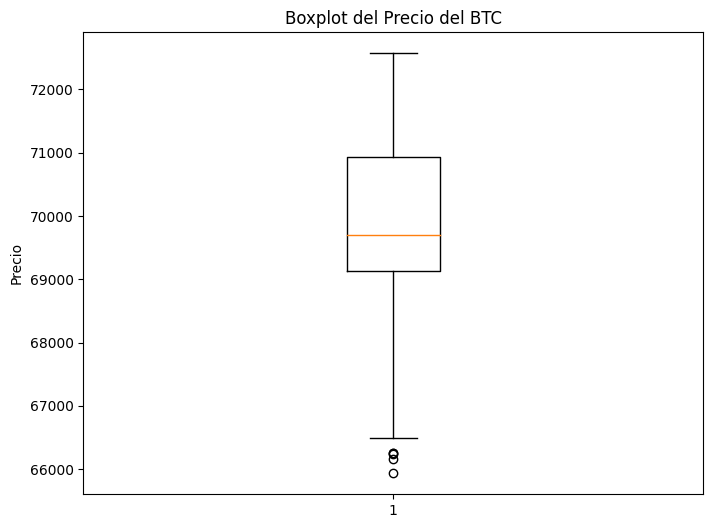

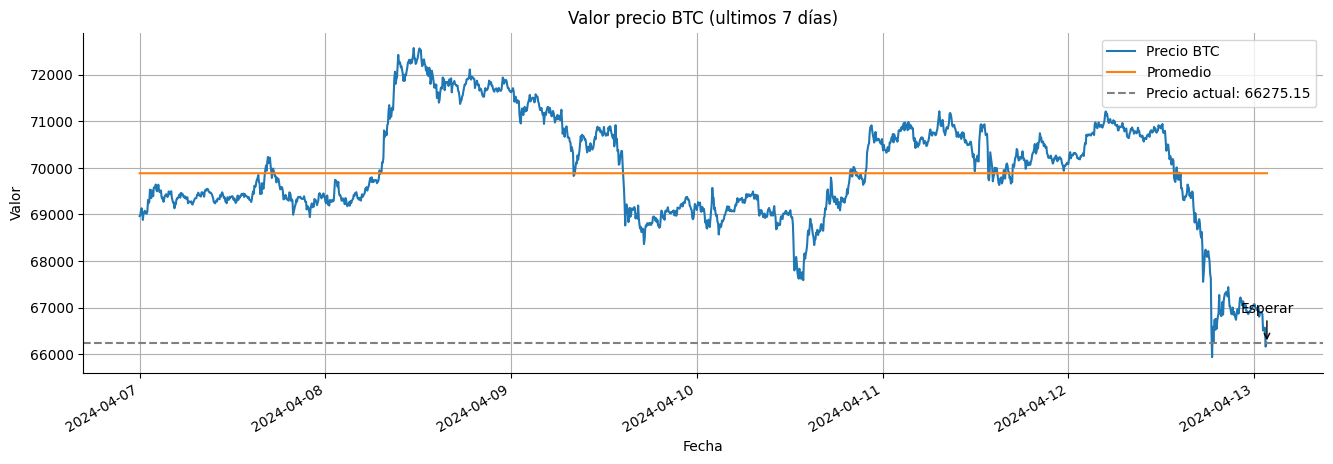

In [ ]:
while(True):
    """
    Ejecuta un ciclo infinito que realiza varias tareas relacionadas con el análisis y visualización de datos de Bitcoin.

    Este bucle ejecuta continuamente una serie de pasos para analizar y visualizar datos de Bitcoin, incluyendo la importación
    de datos, extracción de tendencias, limpieza de datos, toma de decisiones y visualización de resultados. Después de cada
    iteración, espera 300 segundos (5 minutos) antes de comenzar la siguiente iteración.

    Funciones llamadas:
    - importar_base_bitcoin(): Importa datos actualizados de Bitcoin.
    - extraer_tendencias(): Extrae las tendencias actuales del mercado.
    - limpieza_datos(): Realiza la limpieza de los datos de Bitcoin.
    - tomar_decisiones(): Toma decisiones basadas en los datos analizados.
    - visualizacion(): Genera y muestra visualizaciones de los datos y decisiones tomadas.
    - time.sleep(300): Espera 300 segundos (5 minutos) antes de la siguiente iteración.

    Nota: Este bucle se ejecuta indefinidamente hasta que se detenga manualmente.
    """
    clear_output()
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    time.sleep(300)